# Training a Color Classifier with Transfer Learning

In this notebook, we train a convolutional neural network (CNN) to classify flower images by coarse petal color using the heuristic labels developed in `01_exploration.ipynb`. Rather than training a model from scratch, we use transfer learning with a pretrained ResNet18, adapting it to our task through selective
fine-tuning and regularization.

The goals of this notebook are to:

- Apply data augmentation and transfer learning to train a robust image classifier.
- Diagnose training behavior using learning curves and the generalization gap.
- Identify and correct overfitting and underfitting through techniques such as:
  - freezing and unfreezing specific layers,
  - regularization (weight decay),
  - label smoothing,
  - and stronger data augmentation.
- Select the best-performing model checkpoint based on validation performance.

Because the labels used here are generated by a heuristic rather than manual annotation, this notebook places special emphasis on training diagnostics and model behavior, not just final accuracy. The focus is on understanding how the model learns and why certain design choices improve generalization.

The resulting model is saved and evaluated on a held-out test set in the next notebook, `03_evaluation.ipynb`.

## Setting up Random Transforms (Data Augmentation)

When training a CNN, we want it to generalize rather than memorize the exact pixel patterns of the training images. To encourage this, we apply random data augmentations such as flips, rotations, and color jitter. These transforms ensure that the model never sees the exact same version of an image twice, which significantly improves robustness.

Importantly, we do not apply these random transforms to the validation dataset, which should remain stable and unaltered so it can serve as a reliable measure of how well the model performs on unseen data.

We also do a bare-bones, 'truest-to-the-original-image' transformation for creating the heuristic labels.

In [1]:
from torchvision.transforms import v2
import torch

train_tf = v2.Compose([
    v2.RandomResizedCrop(224, scale=(0.8, 1.0)), # Random crop + resize to 224x224
    v2.RandomHorizontalFlip(),                   # Randomly flip images left/right
    v2.RandomVerticalFlip(),                     # Randomly flip images up/down
    v2.RandomRotation(25),                       # Random rotations

    # Strong blur half the time: discourages reliance on texture / fine edges
    v2.RandomApply([v2.GaussianBlur(kernel_size=15, sigma=(0.1, 2.0))], p=0.5),

    # Convert to float image data.
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),

    # Mild noise sometimes: encourages robustness to sensor/lighting variation
    v2.RandomApply([v2.GaussianNoise(mean=0.0, sigma=0.03)], p=0.3),

    # Apply color jitter sometimes to avoid destroying the color signal every time
    v2.RandomApply(
        [v2.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1)],
        p=0.5
    ),
    
    # Normalize using ImageNet means/stds because ResNet18 was pretrained on ImageNet,
    # meaning subtract the ImageNet mean (0.485, etc.) and divide by the ImageNet standard
    # deviation (0.229, etc.) so that the pixel values in each image cluster around 0,
    # each channel has roughly unit variance, and colors are roughly balanced like typical
    # photos. If the pretrained ResNet18 model sees images that do not follow this distribution,
    # its training will not apply correctly.
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225]),
])

# Only necessary transforms for the validation split
val_tf = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225]),
])

# Most basic transform for labeling
label_tf = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
])

## Prepare Datasets

We now construct three dataset objects, each serving a different purpose:

- `label_ds` – used only to generate coarse color labels for the training images.
- `train_ds` – used for actual CNN training with random data augmentations.
- `val_ds` – used for validation (no augmentations; must stay stable).

None of these objects store image data internally. Instead, they provide on-demand access to the image files located in `../data`. Whenever you index a dataset, the corresponding transform (`train_tf` or `label_tf`) is applied at that moment.

This design has two major advantages:

1. Training images are augmented every time they are accessed, which improves generalization.  
2. Validation images remain unchanged, providing a reliable measure of model performance.

In the next step, these datasets will be wrapped in `DataLoader` objects so we can iterate over them in batches during CNN training.

In [2]:
from torchvision.datasets import Flowers102

train_label_ds = Flowers102(root="../data", split="train", download=False, transform=label_tf)
train_ds = Flowers102(root="../data", split="train", download=False, transform=train_tf)
val_label_ds = Flowers102(root="../data", split="val", download=False, transform=label_tf)
val_ds   = Flowers102(root="../data", split="val", download=False, transform=val_tf)

## Recreate Simple Labeling Heuristic from `01_exploration.ipynb`

The next three cells redefine the helper functions (`hue_collector`, `classify_pixel_color`, and `hue_to_color`) so that this notebook can run independently without relying on variables defined earlier.

In [3]:
def hue_collector(img_tensor, center_frac=0.5, stride=6):
    """
    Extract RGB pixel samples from the center region of an image using a fixed stride.

    The goal is to gather a representative set of flower-petal pixels (where the flower
    is usually located) without processing the full image.

    Args:
        img_tensor (torch.Tensor):
            Image tensor of shape [3, H, W], with values in [0, 1].
        center_frac (float):
            Fraction of the image height/width to keep as the center crop.
            For example, 0.5 keeps the central 50% area.
        stride (int):
            Take every Nth pixel in both height and width to reduce sample count.

    Returns:
        pixels (np.ndarray):
            Array of shape [N, 3], containing sampled RGB pixels in [0, 1].
    """

    # Convert PyTorch tensor (C, H, W) -> NumPy array (H, W, C)
    img = img_tensor.permute(1, 2, 0).numpy()
    H, W, _ = img.shape

    # Compute center crop bounds
    crop_h = int(H * center_frac)
    crop_w = int(W * center_frac)
    h0 = (H - crop_h) // 2
    h1 = h0 + crop_h
    w0 = (W - crop_w) // 2
    w1 = w0 + crop_w

    center_region = img[h0:h1, w0:w1, :]  # shape: [crop_h, crop_w, 3]

    # Sample every `stride` pixels for reproducibility and speed
    sampled = center_region[::stride, ::stride, :]  # shape approx: [crop_h/stride, crop_w/stride, 3]

    # Flatten to shape [N, 3]
    pixels = sampled.reshape(-1, 3)
    return pixels

In [4]:
import colorsys

def classify_pixel_color(r, g, b):
    """
    Classify a single pixel into a coarse color category using HSV thresholds.

    Args:
        r, g, b (float): Red, Green, Blue channel values in [0, 1].

    Returns:
        str: One of:
            "white", "red_pink", "orange", "yellow", "green", "purple_blue", or "none".
    """

    # Convert from RGB (0–1) to HSV:
    # h in [0,1) -> hue as a fraction of the color wheel
    # s in [0,1] -> saturation (color intensity)
    # v in [0,1] -> value/brightness
    h, s, v = colorsys.rgb_to_hsv(r, g, b)
    deg = h * 360 # easier to reason about degrees than fractions

    # Heuristic for "white": low saturation but still fairly bright.
    # (These thresholds are intentionally loose; we only need coarse labels.)
    if s < 0.2 and v > 0.7:
        return "white"

    # Hue-based color classification (degrees around the color wheel).
    # Red wraps around 0 degrees, so we combine low and high hue values.
    if deg < 5 or deg >= 300:
        return "red_pink"
    if 5 <= deg < 32:
        return "orange"
    if 32 <= deg < 75:
        return "yellow"
    if 75 <= deg < 165:
        return "green"
    if 165 <= deg < 300:
        return "purple_blue"

    # Fallback for any pixel that doesn't fit the thresholds above.
    return "none"

In [5]:
from collections import Counter

def hue_to_color(pixels, sig_threshold=0.20):
    """
    Assign a single coarse color label to an image, based on the majority color
    of sampled pixels in the center region.

    Args:
        pixels (np.ndarray): Array of shape [N, 3], containing RGB values in [0, 1].
        sig_threshold (float): Minimum fraction a color class must represent
                               to be considered "significant."

    Returns:
        str: One of the coarse color classes, e.g.:
             "purple_blue", "red_pink", "white", "orange", "yellow", "green", or "none".
        bool: True if confident in label assignment, False otherwise.
    """

    # Step 1: classify each sampled pixel
    classes = []
    for r, g, b in pixels:
        cls = classify_pixel_color(r, g, b)
        if cls != "none":
            classes.append(cls)

    # If no classified pixels exist (unlikely but possible), return none.
    if not classes:
        return "none"

    # Step 2: count occurrences of each color class
    counts = Counter(classes)
    total = sum(counts.values())

    # Step 3: determine which colors exceed the significance threshold
    sig_classes = [
        cls for cls, cnt in counts.items()
        if (cnt / total) > sig_threshold
    ]

    # Step 4: If exactly one significant color exists, use it directly
    # and indicate high confidence in it.
    if len(sig_classes) == 1:
        return sig_classes[0]

    # Step 5 (priority resolution):
    # If multiple significant classes exist, choose according to a priority order
    # and indicate low confidence.
    #
    # We prioritize "white" above "orange" and "yellow" because, in practice,
    # those warm colors often come from pollen in the center of otherwise white flowers.
    # Without this rule, many white flowers would be mislabeled as yellow/orange.
    priority = ["purple_blue", "red_pink", "white", "orange", "yellow"]

    for cls in priority:
        if cls in sig_classes:
            return cls

    # Step 6: fallback for edge cases
    return "green"

## Prepare Color-Labeled Datasets

Using the heuristic developed in the previous notebook, we now generate coarse color labels for the training and validation splits. These labels replace the original species labels from Flowers102 and will serve as the target classes for transfer learning on ResNet18.

The workflow here is:

1. Use `label_ds` (no augmentations) to compute heuristic color labels.
2. Wrap those labels together with the augmented `train_ds` or stable `val_ds` inside `ColorLabeledDataset`, which pairs each image with its color label.
3. Filter to include only images labeled with high confidence.

This separates label generation (stable, deterministic) from model training (augmented, randomized), which is an important design pattern in machine learning pipelines.

In [6]:
import sys
sys.path.append("../src")

from tqdm import tqdm
from data.dataset import ColorLabeledDataset
from torch.utils.data import DataLoader, Subset

# Generate heuristic labels for the training split
train_color_labels = []

for i in tqdm(range(len(train_label_ds)), desc="Generating heuristic labels for training"):
    img, _ = train_label_ds[i]
    pixels = hue_collector(img)
    label = hue_to_color(pixels)
    train_color_labels.append(label)

color_train_ds = ColorLabeledDataset(train_ds, train_color_labels)

# Generate heuristic labels for the validation split
val_color_labels = []

for i in tqdm(range(len(val_label_ds)), desc="Generating heuristic labels for validation"):
    img, _ = val_label_ds[i]
    pixels = hue_collector(img)
    label = hue_to_color(pixels)
    val_color_labels.append(label)

color_val_ds = ColorLabeledDataset(val_ds, val_color_labels)

Generating heuristic labels for validation: 100%|██████████████████████████████████| 1020/1020 [00:02<00:00, 368.75it/s]


## What the Model Sees

Above, we defined different transforms for the images based on whether they would be used for creating the heuristic labels, the training data, or the validation data. Below we visually sample a random assortment of images from the sets to better understand what the model 'sees' during training and validation. The normalization of the images- necessary for ResNet18 to apply its prior learning- makes them look strange to humans, but familiar to the model.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0182073..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0424519..1.9083306].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2489083].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.500567].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.639963].
Clippi

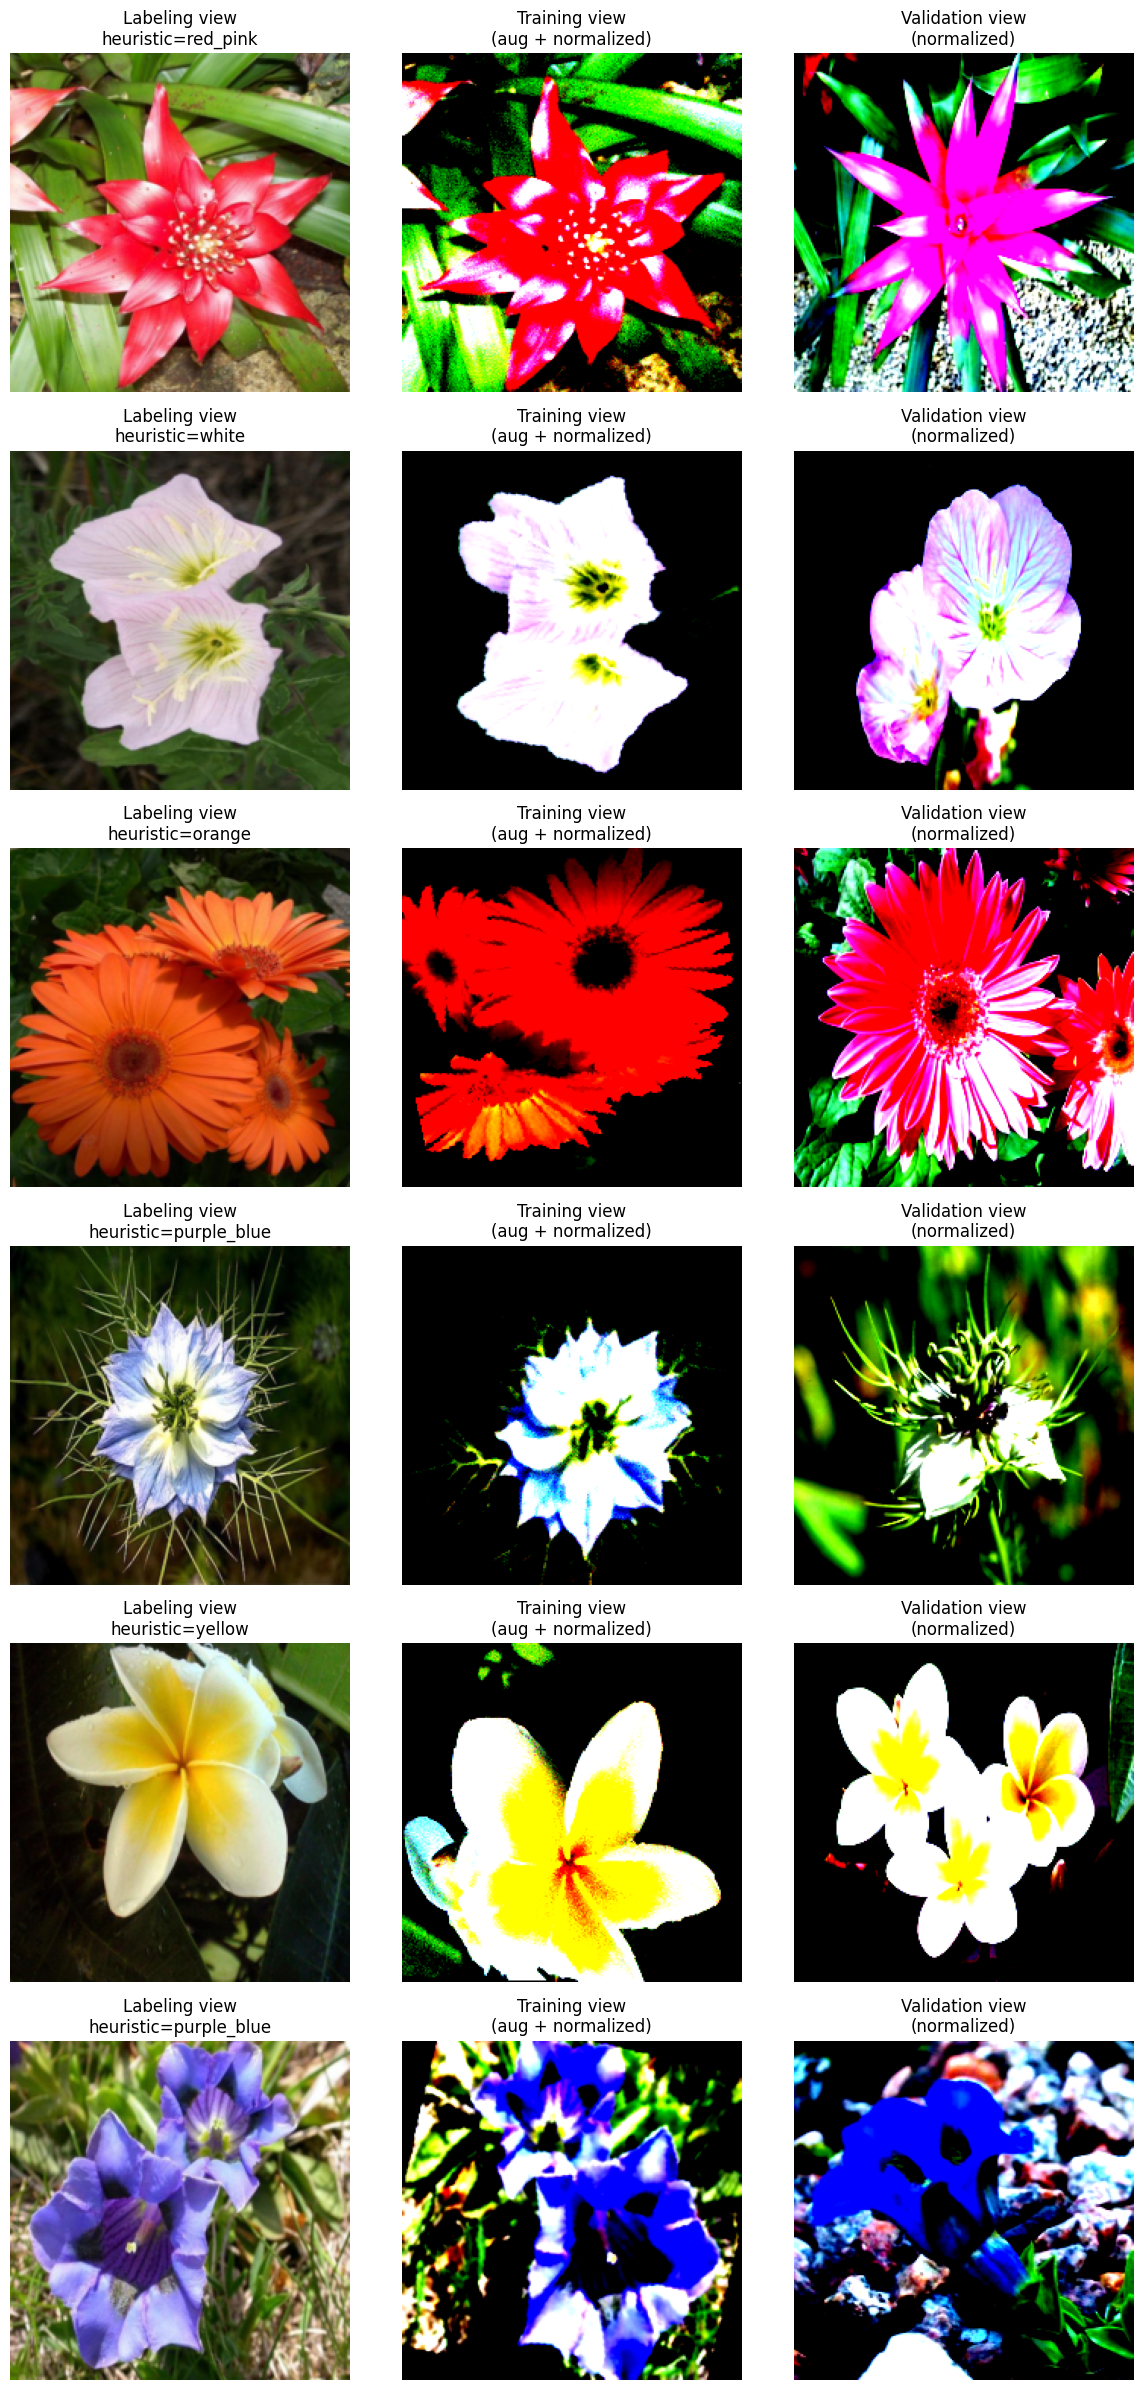

In [14]:
import random
import numpy as np
import matplotlib.pyplot as plt
import torch

def to_numpy(img):
    """
    Convert [3,H,W] tensor to HxWx3 numpy for imshow.
    NOTE: This does NOT de-normalize.
    """
    return img.detach().cpu().permute(1, 2, 0).numpy()

# Number of examples to show
N = 6

# Choose indices safely
max_idx = min(len(train_label_ds), len(train_ds), len(val_ds))
indices = random.sample(range(max_idx), k=min(N, max_idx))

fig, axes = plt.subplots(len(indices), 3, figsize=(12, 4 * len(indices)))

if len(indices) == 1:
    axes = np.array([axes])

for row, i in enumerate(indices):
    # Labeling view (human-readable RGB)
    img_label, _ = train_label_ds[i]
    px = hue_collector(img_label)
    heur_label = hue_to_color(px)

    # Training view (augmented + normalized)
    img_train, _ = train_ds[i]

    # Validation view (normalized)
    img_val, _ = val_ds[i]

    # Labeling
    ax = axes[row, 0]
    ax.imshow(to_numpy(img_label))
    ax.set_title(f"Labeling view\nheuristic={heur_label}")
    ax.axis("off")

    # Training (normalized)
    ax = axes[row, 1]
    ax.imshow(to_numpy(img_train))
    ax.set_title("Training view\n(aug + normalized)")
    ax.axis("off")

    # Validation (normalized)
    ax = axes[row, 2]
    ax.imshow(to_numpy(img_val))
    ax.set_title("Validation view\n(normalized)")
    ax.axis("off")

plt.tight_layout()
plt.show()

## Create DataLoaders

PyTorch uses `DataLoader` objects to provide batches of `(image, label)` pairs during training and evaluation. This abstraction handles batching, shuffling, and background data loading so that the GPU can stay busy while new data is prepared.

- The training loader shuffles the dataset and applies random augmentations.
- The validation loader does not shuffle and uses deterministic preprocessing.

Keeping the validation loader stable ensures our accuracy metrics are meaningful and comparable across epochs.


In [15]:
train_loader = DataLoader(
    color_train_ds,
    batch_size=32, # How many (image, label) pairs to return at once.
                   # Larger batches can speed up training but require more GPU memory.
    shuffle=True,  # Shuffling during training ensures the model can't rely on any
                   # ordering patterns in the dataset, improving generalization.
    num_workers=4  # How many background subprocesses to use for loading data.
)

val_loader = DataLoader(
    color_val_ds,
    batch_size=32,
    shuffle=False, # No shuffling during validation so evaluation metrics stay
                   # stable across epochs.
    num_workers=4
)

## Initialize the ResNet18 Model for Transfer Learning

Now that we have our labeled datasets and DataLoaders, we can initialize the model we will train: a *ResNet18* convolutional neural network.

Instead of training a CNN from scratch, we use transfer learning, which allows us to start from a model that was already pretrained on the large ImageNet dataset. This has two major advantages:

1. The early layers of ResNet18 already know how to detect general visual patterns such as edges, textures, and shapes.
2. We only need to replace and train the final classification layer, which we customize to output one prediction for each of our coarse color classes.

Here’s what happens in the code below:

- We choose whether to use a GPU (`device = "cuda"`) or fall back to CPU.
- We call `get_resnet18(num_classes)` to create a ResNet18 model whose final layer has the correct number of output units for our color classes.
- We define a loss function (*`CrossEntropyLoss`*) appropriate for multi-class classification.
- We define an optimizer (*AdamW*) that will update the model weights during training.

Once these pieces are in place, we will begin the training loop where the model learns to map flower images to their predicted color labels.

In [9]:
import torch
from models.classifier import get_resnet18

# Choose device: GPU if available, else CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# Initialize a ResNet18 with the correct number of output classes.
# get_resnet18(N) replaces the final fully-connected layer with one that outputs N logits
# (raw class scores prior to softmax).
model = get_resnet18(len(color_train_ds.classes)).to(device)

# Loss function for multi-class classification (expects logits + integer class labels).
# We use relatively strong label smoothing because our labels come from a heuristic and
# may contain noise. Label smoothing reduces overconfidence by softening the target
# distribution (i.e., the correct class is encouraged to be "mostly" correct, not 100%).
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.2)

# Determine which parts of the pretrained CNN will be updated during training.
# First, freeze all parameters so pretrained weights are not modified by default.
for p in model.parameters():
    p.requires_grad = False

# Then selectively unfreeze:
# - the final residual block (layer4.1), which captures high-level visual features
# - the final fully connected classification layer
# This provides limited task-specific flexibility while helping reduce overfitting risk.
for p in model.layer4[1].parameters():
    p.requires_grad = True
for p in model.fc.parameters():
    p.requires_grad = True

# AdamW optimizer (commonly used with weight decay).
# Weight decay (L2 regularization) discourages overly large weight values and can improve
# generalization. We use a small learning rate to make smaller, more stable updates during fine-tuning.
opt = torch.optim.AdamW(
    (p for p in model.parameters() if p.requires_grad),
    lr=1e-5,
    weight_decay=1e-4
)

Device: cuda


## Check Model Freezing

Before training, it is important to verify which parts of the network will actually be updated during optimization. We count how many parameters are trainable versus frozen and print the names of each parameter, with an indication of whether it will be updated during training.

This serves as a sanity check that our fine-tuning strategy (training only the final residual block and classifier head) is implemented correctly.

In [10]:
# Count total and trainable parameters
total = sum(p.numel() for p in model.parameters())
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Trainable parameters: {trainable:,} / {total:,} ({trainable / total:.1%})")
print("\nParameter status:")

# List which parameters are frozen vs trainable
for name, param in model.named_parameters():
    status = "TRAIN" if param.requires_grad else "FROZE"
    print(f"{status:5} : {name}")

Trainable parameters: 4,723,718 / 11,179,590 (42.3%)

Parameter status:
FROZE : conv1.weight
FROZE : bn1.weight
FROZE : bn1.bias
FROZE : layer1.0.conv1.weight
FROZE : layer1.0.bn1.weight
FROZE : layer1.0.bn1.bias
FROZE : layer1.0.conv2.weight
FROZE : layer1.0.bn2.weight
FROZE : layer1.0.bn2.bias
FROZE : layer1.1.conv1.weight
FROZE : layer1.1.bn1.weight
FROZE : layer1.1.bn1.bias
FROZE : layer1.1.conv2.weight
FROZE : layer1.1.bn2.weight
FROZE : layer1.1.bn2.bias
FROZE : layer2.0.conv1.weight
FROZE : layer2.0.bn1.weight
FROZE : layer2.0.bn1.bias
FROZE : layer2.0.conv2.weight
FROZE : layer2.0.bn2.weight
FROZE : layer2.0.bn2.bias
FROZE : layer2.0.downsample.0.weight
FROZE : layer2.0.downsample.1.weight
FROZE : layer2.0.downsample.1.bias
FROZE : layer2.1.conv1.weight
FROZE : layer2.1.bn1.weight
FROZE : layer2.1.bn1.bias
FROZE : layer2.1.conv2.weight
FROZE : layer2.1.bn2.weight
FROZE : layer2.1.bn2.bias
FROZE : layer3.0.conv1.weight
FROZE : layer3.0.bn1.weight
FROZE : layer3.0.bn1.bias
FROZE 

## Training Loop: Running One Epoch of Training and Validation

With our model, loss function, optimizer, and DataLoaders prepared, we can now define the training loop. Training a neural network in PyTorch generally follows this pattern:

1. Iterate over the dataset in batches using a DataLoader.
2. Run the model forward to compute predictions.
3. Compute the loss, which measures how far predictions are from the true labels.
4. Backpropagate (if training) to compute gradients.
5. Update the model parameters using the optimizer.
6. Track useful metrics such as:
   - the average loss for the epoch  
   - the classification accuracy  

Thinking metaphorically can help clarify the concepts involved. Consider the model as a recipe in a test kitchen. One station chops vegetables, the next seasons the dish, the next cooks the meal, and the last plates the food. These stations correspond to the layers of the CNN. At the end, a food critic tastes the dish: this is the loss function.

The critic returns a single number that represents how far from perfect the dish is. Then- and this is the trickiest part to understand- the critic walks backwards through the kitchen and tells each station how to adjust its part of the process so the next attempt will be closer to perfection. This backward flow of feedback is backpropagation.

How does the critic know exactly what changes to suggest? By measuring how much each station’s work contributed to the final score of the dish. Each layer of the CNN uses a set of weights to transform its input. The direction and magnitude of the change in the final loss caused by adjusting those weights tells the model how much and in which direction to update them.

We wrap this logic inside a helper function called `run_epoch()`, which can operate in two modes:

- `train=True`: the model is updated (backpropagation + optimizer step)
- `train=False`: the model runs in evaluation mode (no gradient updates)

After defining the function, we run it once per epoch for both the training and validation splits, storing the history of loss and accuracy. This gives us everything we need to assess and visualize how the model learns over time.

In [11]:
from tqdm import tqdm
import numpy as np

def run_epoch(model, loader, train=True):
    # Set model mode:
    #  - train=True: enable dropout, BN updates, gradient calculation
    #  - train=False: evaluation mode (no gradient updates)
    model.train(train)

    losses = []
    correct = 0
    total = 0

    # Iterate over batches in the DataLoader
    for x, y in tqdm(loader, leave=False):
        # Move batch to GPU (or CPU fallback)
        x, y = x.to(device), y.to(device)

        # Reset gradients only when training
        if train:
            opt.zero_grad()

        # Forward pass: compute logits- raw scores per flower petal color
        pred = model(x)

        # Compute loss for this batch
        loss = loss_fn(pred, y)

        # Backpropagation and optimization step
        if train:
            loss.backward()
            opt.step()

        # Track metrics
        losses.append(loss.item())
        correct += (pred.argmax(1) == y).sum().item()
        total += y.size(0)

    # Return average loss and accuracy for this epoch
    return np.mean(losses), correct / total

## Run Training Across Multiple Epochs

With the training loop defined, we can now train the model for several epochs. An epoch represents one full pass through the entire training dataset.

At each epoch, we:

1. Train the model on the training set (with random augmentations enabled).
2. Evaluate the model on the validation set (no weight updates).
3. Record both loss and accuracy so we can track learning progress over time.

By storing these metrics after every epoch, we can later visualize how the model’s performance evolves and check for issues such as underfitting or overfitting.

Because we are using transfer learning with a pretrained ResNet18 and a relatively small dataset, the model typically converges quickly. A small number of epochs (20) is often sufficient to reach good performance without overfitting.

During training, the model’s performance on the validation set may improve for several epochs and then begin to plateau or degrade as overfitting sets in. Rather than always keeping the weights from the final epoch, we track the best validation performance and save the model weights from the epoch where validation accuracy is highest. This ensures that downstream evaluation uses the version of the model that generalized best to unseen data, not necessarily the one trained the longest.


In [12]:
import torch

num_epochs = 20

# Store (loss, accuracy) pairs for later visualization
train_hist = []
val_hist = []

best_val_acc = -1.0
best_model_path = "../results/best_model_weights.pt"

for epoch in range(num_epochs):
    # Training phase
    tr_loss, tr_acc = run_epoch(
        model,
        train_loader,
        train=True
    )

    # Validation phase
    va_loss, va_acc = run_epoch(
        model,
        val_loader,
        train=False
    )

    # Record metrics
    train_hist.append((tr_loss, tr_acc))
    val_hist.append((va_loss, va_acc))

    # Checkpoint the best model based on validation accuracy
    if va_acc > best_val_acc:
        best_val_acc = va_acc
        torch.save(model.state_dict(), best_model_path)
        saved_msg = " saved best model"
    else:
        saved_msg = ""

    # Print epoch summary
    print(
        f"Epoch {epoch + 1:02d}: "
        f"train loss={tr_loss:.3f}, "
        f"train acc={tr_acc:.3f}, "
        f"val acc={va_acc:.3f}"
        f"{saved_msg}"
    )


Epoch 01: train loss=1.993, train acc=0.175, val acc=0.218 saved best model


Epoch 02: train loss=1.768, train acc=0.268, val acc=0.313 saved best model


Epoch 03: train loss=1.605, train acc=0.420, val acc=0.458 saved best model


Epoch 04: train loss=1.477, train acc=0.575, val acc=0.540 saved best model


Epoch 05: train loss=1.387, train acc=0.638, val acc=0.630 saved best model


Epoch 06: train loss=1.328, train acc=0.688, val acc=0.675 saved best model


Epoch 07: train loss=1.274, train acc=0.718, val acc=0.687 saved best model


Epoch 08: train loss=1.221, train acc=0.739, val acc=0.715 saved best model


Epoch 09: train loss=1.188, train acc=0.760, val acc=0.727 saved best model


Epoch 10: train loss=1.168, train acc=0.766, val acc=0.728 saved best model


Epoch 11: train loss=1.148, train acc=0.776, val acc=0.740 saved best model


Epoch 12: train loss=1.126, train acc=0.793, val acc=0.746 saved best model


Epoch 13: train loss=1.113, train acc=0.787, val acc=0.747 saved best model


Epoch 14: train loss=1.114, train acc=0.777, val acc=0.752 saved best model


Epoch 15: train loss=1.100, train acc=0.783, val acc=0.756 saved best model


Epoch 16: train loss=1.087, train acc=0.800, val acc=0.756


Epoch 17: train loss=1.089, train acc=0.806, val acc=0.757 saved best model


Epoch 18: train loss=1.083, train acc=0.802, val acc=0.758 saved best model


Epoch 19: train loss=1.081, train acc=0.793, val acc=0.767 saved best model


Epoch 20: train loss=1.064, train acc=0.816, val acc=0.764


## Training Diagnostics: Learning Behavior and Generalization

To understand how the model learns over time—and whether it generalizes beyond the training data—we examine three complementary diagnostics plotted across training epochs:

1. Loss vs. Epoch (training and validation)
2. Accuracy vs. Epoch (training and validation)
3. Generalization Gap (training accuracy − validation accuracy)

Together, these curves provide a compact but powerful summary of training behavior.

### Interpreting the learning curves (loss and accuracy)

- Healthy learning:  
  Training loss decreases and validation loss decreases or stabilizes, while validation accuracy increases alongside training accuracy. This suggests the model is learning meaningful, generalizable features.

- Overfitting: 
  Training loss continues to decrease while validation loss begins to increase, or training accuracy rises while validation accuracy plateaus or declines. This indicates the model is memorizing training-specific details rather than learning broadly useful representations.

- Underfitting:
  Both training and validation accuracy remain low and improve slowly. This suggests the model lacks sufficient capacity, training time, or signal (e.g., noisy labels) to learn the task effectively.

### Interpreting the generalization gap

The generalization gap is defined as:

**generalization gap = training accuracy − validation accuracy**

This single value summarizes how differently the model performs on seen (training) versus unseen (validation) data.

As a rule of thumb for image classification tasks:

- Gap ≤ 0.03 (0–3 percentage points):
  Typically indicates strong generalization.

- Gap ≈ 0.03–0.08 (3–8 percentage points):
  Often acceptable in practice, especially when using data augmentation, transfer learning, or heuristic/noisy labels.

- Gap ≥ 0.08–0.10 (8–10+ percentage points):
  A warning sign of overfitting. The model is likely learning patterns specific to the training data rather than features that generalize well.

Importantly, the trend of the gap over time is often more informative than its exact magnitude. A gap that grows steadily across epochs while validation accuracy stalls or declines is a strong indicator of overfitting.

### Why these diagnostics matter here

Because the labels in this project are generated by a heuristic (and therefore contain some noise), training behavior can be subtle to interpret from accuracy alone. Examining loss curves alongside the generalization gap helps guide decisions such as adjusting regularization and data augmentation, or freezing more layers of the pretrained network.

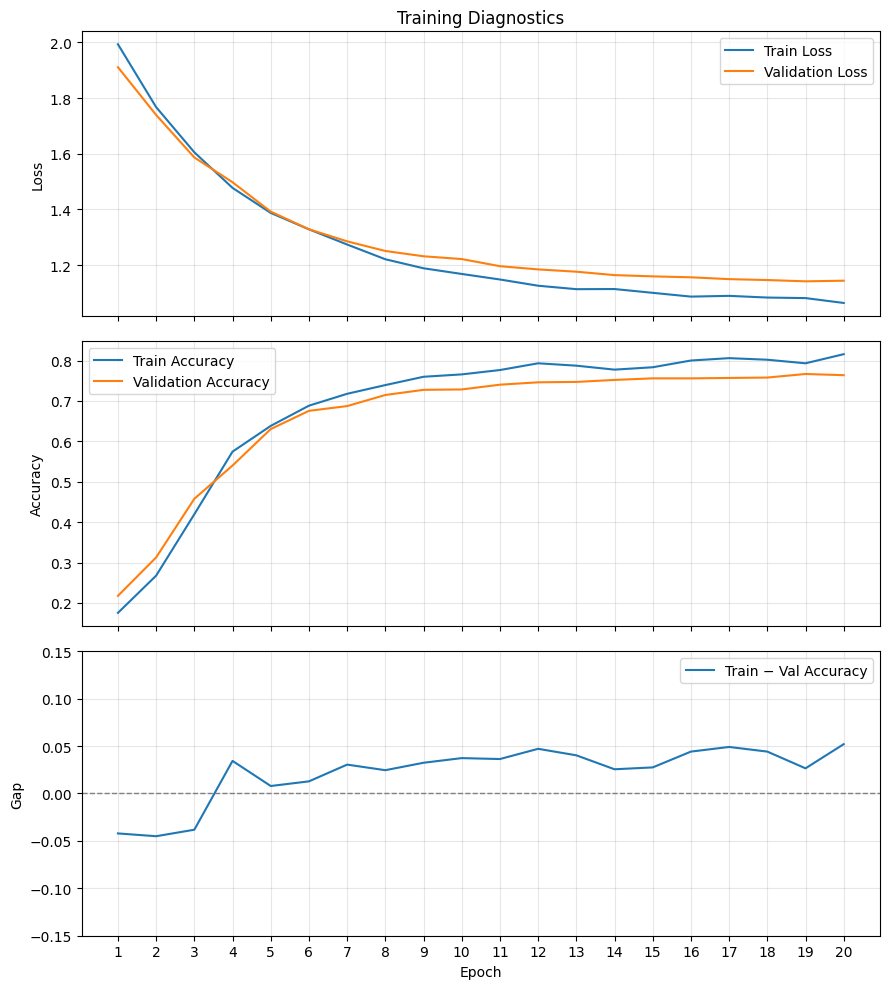

In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Unpack history
train_loss = [x[0] for x in train_hist]
train_acc  = [x[1] for x in train_hist]
val_loss   = [x[0] for x in val_hist]
val_acc    = [x[1] for x in val_hist]

epochs = np.arange(1, len(train_loss) + 1)

# Generalization gap
gap = [tr - va for tr, va in zip(train_acc, val_acc)]

# Ensure results directory exists
os.makedirs("../results", exist_ok=True)

# Create a single figure with 3 stacked subplots
fig, axes = plt.subplots(
    nrows=3,
    ncols=1,
    figsize=(9, 10),
    sharex=True
)

# Loss vs Epoch
axes[0].plot(epochs, train_loss, label="Train Loss")
axes[0].plot(epochs, val_loss, label="Validation Loss")
axes[0].set_ylabel("Loss")
axes[0].set_title("Training Diagnostics")
axes[0].legend()
axes[0].grid(alpha=0.3)

# Accuracy vs Epoch
axes[1].plot(epochs, train_acc, label="Train Accuracy")
axes[1].plot(epochs, val_acc, label="Validation Accuracy")
axes[1].set_ylabel("Accuracy")
axes[1].legend()
axes[1].grid(alpha=0.3)

# Generalization Gap
axes[2].plot(epochs, gap, label="Train − Val Accuracy")
axes[2].axhline(0, linestyle="--", color="gray", linewidth=1)
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("Gap")
axes[2].set_ylim(-0.15, 0.15)
axes[2].legend()
axes[2].grid(alpha=0.3)

# Final layout tweaks
plt.xticks(epochs)
plt.tight_layout()
plt.savefig("../results/training_diagnostics.png", dpi=200)
plt.show()


## Interpreting and Responding to Learning Curves

The learning curves above help us understand how the model is learning, not just how well it performs. When training does not behave as expected, these plots with the generalization gap point to specific adjustments we can try.

### Overfitting
Overfitting occurs when the model performs very well on the training data but fails to generalize to new, unseen images. In the diagnostics above, this often appears as:

- training loss continuing to decrease, while  
- validation loss stops improving or begins to increase, and  
- validation accuracy plateaus or drops.

This behavior is often accompanied by a growing generalization gap, where training accuracy continues to rise but validation accuracy does not. Together, these signals suggest the model is memorizing details specific to the training images rather than learning broadly useful features.

Common strategies to reduce overfitting include:

- Increasing data augmentation, which exposes the model to more varied versions of each image and encourages it to learn robust, generalizable features.
- Reducing model capacity, for example by freezing more of the pretrained layers so fewer parameters are free to over-specialize.
- Adding regularization, such as weight decay, which discourages overly large weight values that can lead to memorization.
- Stopping training earlier (early stopping), once validation performance stops improving.

### Underfitting
Underfitting occurs when the model fails to learn the underlying patterns in the data. In the diagnostics above, this often appears as:

- both training and validation accuracy remaining low, and  
- losses decreasing only slowly or not at all.

In this case, the generalization gap is typically small, but overall performance is poor on both splits. This indicates the model does not yet have enough capacity, training time, or signal to represent the task effectively.

Common strategies to address underfitting include:

- Training for more epochs, giving the model additional opportunities to learn.
- Unfreezing additional pretrained layers, allowing more of the network to adapt to the specific dataset.
- Increasing model capacity or reducing regularization constraints, if the model is overly constrained.
- Improving label quality, for example by refining heuristic labels or reducing label noise.

In practice, these adjustments are explored iteratively. After each change, the learning curves and generalization gap are examined again to assess whether training behavior has improved. Once the diagnostics indicate healthy learning and acceptable generalization, we proceed to final evaluation on the held-out test set in the next notebook.